<a href="https://colab.research.google.com/github/Arta-DS/py_analytics_HWs/blob/main/%D0%9C%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8_ARMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%matplotlib inline

<ipython-input-64-7b3e0f2a59ec>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('weekly-closings-of-the-dowjones-.csv', index_col='Week', parse_dates=True)


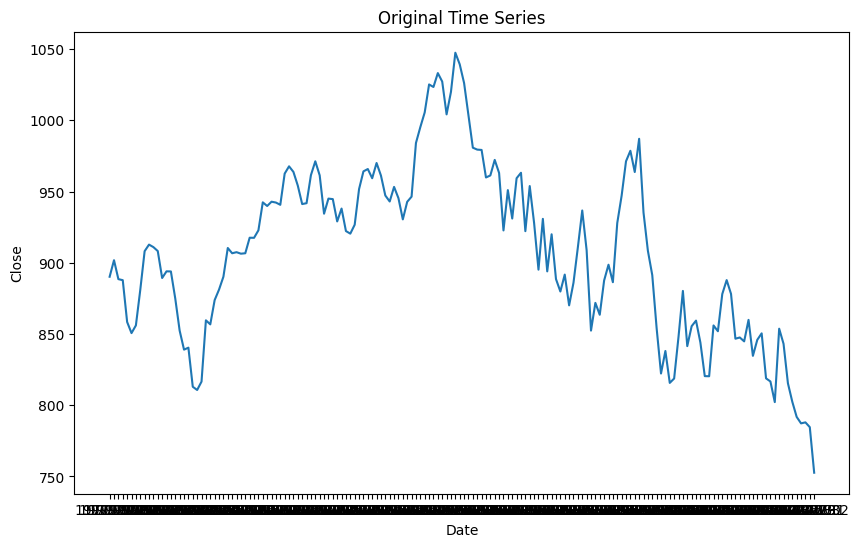

In [64]:
df = pd.read_csv('weekly-closings-of-the-dowjones-.csv', index_col='Week', parse_dates=True)

# Визуализация исходного временного рядя
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Close'])
plt.title('Original Time Series')
plt.xlabel('Date')
plt.ylabel('Close')
plt.show()

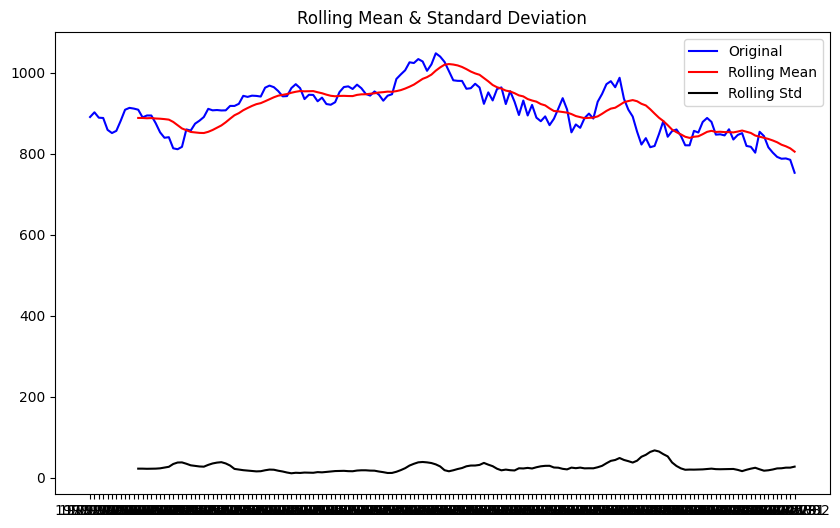

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


In [65]:
# Проверим стационарность временного ряда с помощью теста Дики-Фуллера
def test_stationarity(timeseries):
    # Определим rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    # Plot rolling statistics:
    fig = plt.figure(figsize=(10, 6))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(df['Close'])

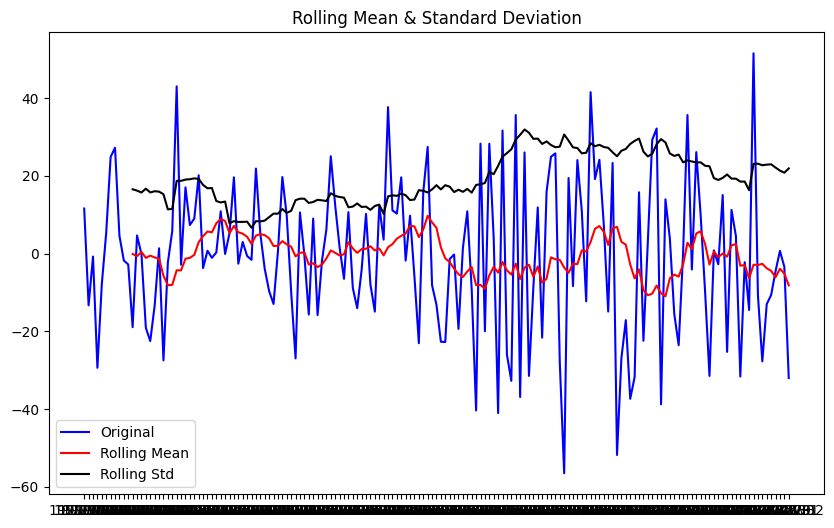

Results of Dickey-Fuller Test:
Test Statistic                -1.302521e+01
p-value                        2.407586e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


In [66]:
# Применим первую разность для достижения стационарности
diff_series = df['Close'].diff().dropna()

# Проверим стационарность после первой разности
test_stationarity(diff_series)

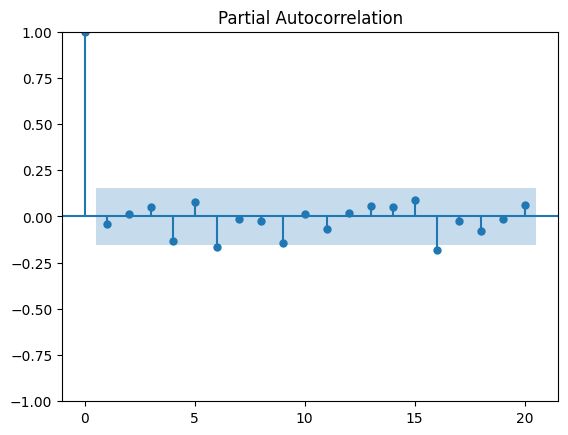

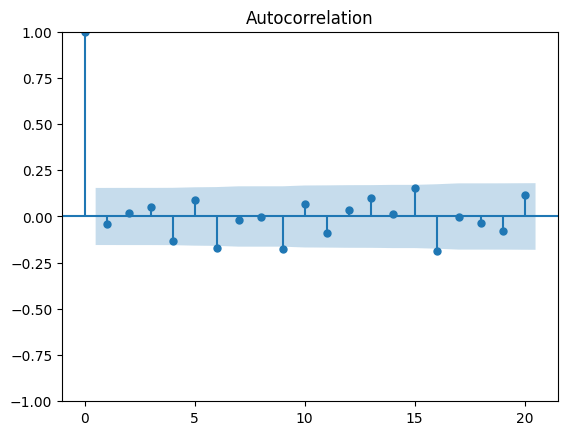

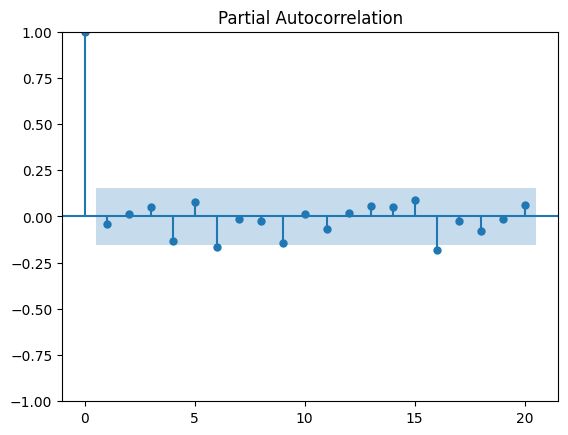

In [67]:
# Построение ACF и PACF для выбора порядка модели ARIMA
plot_acf(diff_series, lags=20)
plot_pacf(diff_series, lags=20)

In [68]:
# Построим модель ARIMA
model = ARIMA(diff_series, order=(2, 1, 2))
results_ARIMA = model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a 

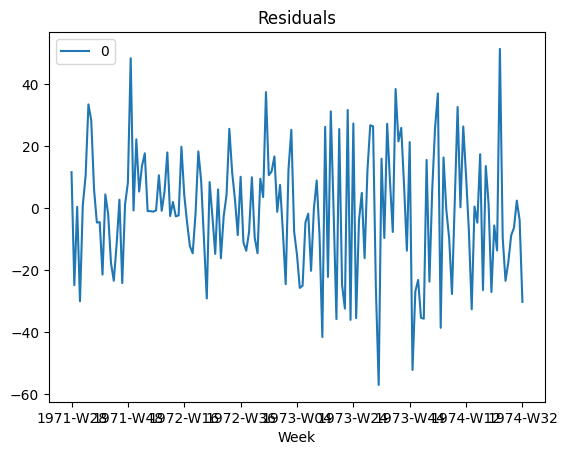

In [69]:
# Оценим качество модели
residuals = pd.DataFrame(results_ARIMA.resid)
residuals.plot(title="Residuals")
plt.show()

In [70]:
# Прогнозируем значения
pred_start_index = len(df)
pred_end_index = pred_start_index + 52  # прогноз на год вперед
forecast = results_ARIMA.predict(start=pred_start_index, end=pred_end_index)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [71]:
print(len(forecast.values))  # Длина массива значений прогноза
print(len(df) - pred_start_index)  # Количество строк, начиная с pred_start_index

53
0


In [73]:
pred_start_index = len(df) - len(forecast.values)
if pred_start_index >= 0:
    df.iloc[pred_start_index:, df.columns.get_loc('Forecast')] = forecast.values
else:
    print("Не хватает строк для добавления прогноза!")

In [74]:
# Добавим прогноз в исходный DataFrame
df['Forecast'] = np.nan
df.iloc[pred_start_index:, df.columns.get_loc('Forecast')] = forecast.values

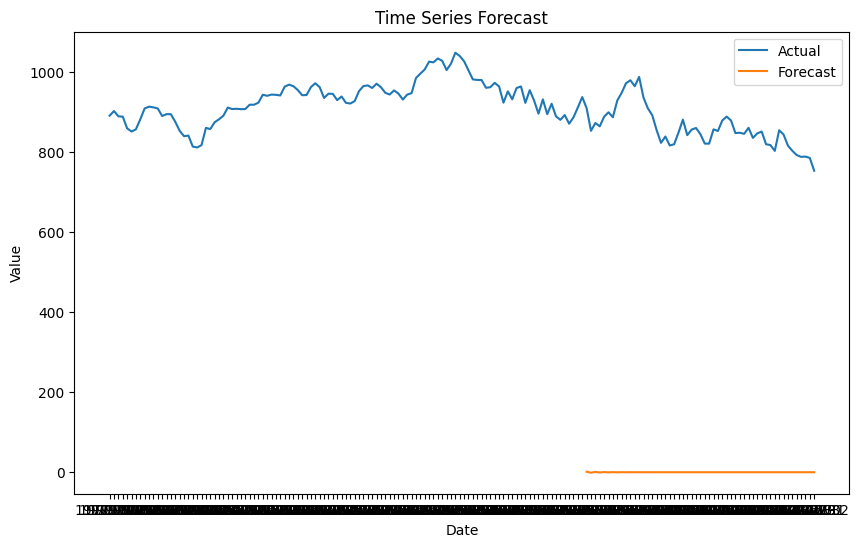

In [79]:
# Визуализируем исходные данные и прогноз
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Close'], label='Actual')
plt.plot(df.index, df['Forecast'], label='Forecast')
plt.title('Time Series Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()